In [ ]:
# Using ktrain as a lightweight wrapper for our BERT model
!pip install ktrain

     |████████████████████████████████| 25.3MB 68.0MB/s 
     |████████████████████████████████| 6.8MB 56.0MB/s 
     |████████████████████████████████| 983kB 54.8MB/s 
     |████████████████████████████████| 266kB 50.3MB/s 
     |████████████████████████████████| 1.3MB 42.0MB/s 
     |████████████████████████████████| 1.2MB 49.5MB/s 
     |████████████████████████████████| 471kB 51.5MB/s 
     |████████████████████████████████| 890kB 47.3MB/s 
     |████████████████████████████████| 2.9MB 50.7MB/s 
  Created wheel for ktrain: filename=ktrain-0.25.3-cp36-none-any.whl size=25276312 sha256=51fc4a3f1d4603472a45c41b9374d151d003c7755970a297ec50f3e1acf41a9b
  Stored in directory: /root/.cache/pip/wheels/86/cd/9c/ad53b98a3eccf4ddeddccfce99d353781f206a1ac4287ca721
  Created wheel for langdetect: filename=langdetect-1.0.8-cp36-none-any.whl size=993194 sha256=f060fc55121c81e4e8c681c29b3f153c150b83344c8b0a9054baaf871cbc5d0b
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d

# **MultinomialNB**

In [ ]:
import nltk
import pandas as pd
import numpy as np
import time
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix,classification_report, plot_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
import ktrain
import tensorflow as tf
from ktrain import text
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline


In [ ]:
#Getting the training, validation, and testing data, and exploring the data

train = pd.read_csv("train.txt", delimiter=';', header=None, names=['sentence','label'])
test = pd.read_csv("test.txt", delimiter=';', header=None, names=['sentence','label'])
val = pd.read_csv("val.txt", delimiter=';', header=None, names=['sentence','label'])

train_data = pd.concat([train,val])
test_data = test

train_data.head()

,sentence,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [ ]:
X_train = train_data['sentence']
X_test = test['sentence']

y_train = train_data['label']
y_test = test['label']

In [ ]:
#a grid search to find the best parameters: 

from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction import DictVectorizer

pipe = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', MultinomialNB()),
])

parameters = {'clf__alpha': [1,0.1, 0.3],
              'vect__ngram_range': [(1,1),(1,2), (2,2)],
              'vect__binary' : [True, False]
              }

grid_search_start = time.time()
GSR = GridSearchCV(estimator = pipe, param_grid = parameters, cv = 5)
#Fitting the model
fit = GSR.fit(X_train, y_train)

print('Grid search has taken: ', time.time() - grid_search_start, ' Seconds')

In [ ]:
#calculating the score and getting the best parameters, 

GSR.score(X_test, y_test)
print('The best parameters are: \n', GSR.best_params_)
print('The best estimator is: \n', GSR.best_estimator_)

The best parameters are: 
 {'clf__alpha': 0.3, 'vect__binary': True, 'vect__ngram_range': (1, 1)}
The best estimator is: 
 Pipeline(steps=[('vect', CountVectorizer(binary=True)),
                ('clf', MultinomialNB(alpha=0.3))])


In [ ]:
#Fitting a pipeline with CountVectorizer vectorizer and multinomial naive bayes classifier

pipe = Pipeline([
    ('vect', CountVectorizer(max_df=0.95, min_df=2, stop_words='english')),
    ('clf', MultinomialNB(alpha=0.3))
])
#After testing with different values for 'alpha', 0.3 has scored the highest.



#Fitting the model
fit = pipe.fit(X_train, y_train)

#Calculating the score of our predictor
pipe.score(X_test, y_test)

0.829

In [ ]:
#predicting on the test data 

predicted = pipe.predict(X_test)

In [ ]:
#calculating the score, precision, recall, and F1 values

acc_score = metrics.accuracy_score(predicted,y_test)
prec_score = precision_score(y_test,predicted, average='macro')
recall = recall_score(y_test, predicted,average='macro')
f1 = f1_score(y_test,predicted,average='macro')
matrix = confusion_matrix(y_test,predicted)

In [ ]:
print(str('Accuracy: '+'{:04.2f}'.format(acc_score*100))+'%')
print(str('Precision: '+'{:04.2f}'.format(prec_score*100))+'%')
print(str('Recall: '+'{:04.2f}'.format(recall*100))+'%')
print('F1 Score: ',f1)
print(matrix)

Accuracy: 82.90%
Precision: 78.37%
Recall: 73.83%
F1 Score:  0.7577094282644804
[[218  13  15   2  24   3]
 [ 13 169  12   1  24   5]
 [  4   6 632  29  20   4]
 [  2   1  44 100  11   1]
 [ 21   8  34   6 508   4]
 [  3  16  11   0   5  31]]


Text(0.5, 1.0, 'Confusion matrix for naive bayes classifier \n')

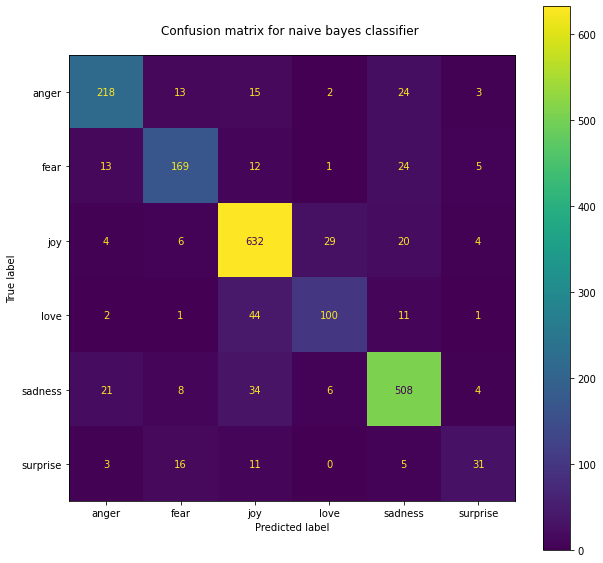

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(fit, X_test, y_test, ax=ax)
plt.title('Confusion matrix for MNB classifier \n')


# **BERT**

In [ ]:
train_data.head()

,sentence,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [ ]:
X_train = train_data['sentence']
y_train = train_data['label']
X_test = test_data['sentence']
y_test = test_data['label']


bert_x_train = train['sentence'] 
bert_x_test = test['sentence']
bert_y_train = train['label']
bert_y_test = test['label']
bert_x_val = val['sentence']
bert_y_val = val['label']

In [ ]:
# df_train.Sentiment.value_counts()

In [ ]:
bert_x_train = train.sentence.tolist()
bert_x_test = test.sentence.tolist()
bert_y_train = train.label.tolist()
bert_y_test = test.label.tolist()
bert_x_val = val.sentence.tolist()
bert_y_val = val.label.tolist()

In [ ]:
#The sentiments:  

factors = ['anger', 'fear', 'joy', 'love', 'sadness','surprise']

In [ ]:
encoding = { 'anger': 0,
    'fear': 1,
    'joy': 2,
    'love': 3,
    'sadness': 4,
    'surprise': 5
}

In [ ]:
#Encoding the labels (classes)

bert_y_train = [encoding[key] for key in bert_y_train]
bert_y_test = [encoding[key] for key in bert_y_test]
bert_y_val = [encoding[key] for key in bert_y_val]

In [ ]:
#downloading pretrained BERT model and using BERT preprocessing mode

(x_train_bert, y_train_bert), (x_val_bert, y_val_bert), preproc = text.texts_from_array(x_train=bert_x_train,
                                                                                        y_train = bert_y_train,
                                                                                        x_test = bert_x_test,
                                                                                        y_test = bert_y_test,
                                                                                        class_names = factors,
                                                                                        preprocess_mode = 'bert',
                                                                                        lang = 'en',
                                                                                        maxlen = 512)

downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


task: text classification


In [ ]:
model = text.text_classifier('bert', train_data=(x_train_bert, y_train_bert), preproc=preproc)

# wrap model and data in a Learner object
learner = ktrain.get_learner(model, train_data=(x_train_bert, y_train_bert), val_data=(x_val_bert, y_val_bert),
                             batch_size = 6)

Is Multi-Label? False
maxlen is 512
done.


simulating training for different learning rates... this may take a few moments...
Epoch 1/10
2667/2667 [==============================] - 4461s 2s/step - loss: 1.9825 - accuracy: 0.1875
Epoch 2/10
2667/2667 [==============================] - 4407s 2s/step - loss: 1.4517 - accuracy: 0.4324
Epoch 3/10
2667/2667 [==============================] - 4386s 2s/step - loss: 0.3603 - accuracy: 0.8774
Epoch 4/10
2667/2667 [==============================] - 4390s 2s/step - loss: 0.2422 - accuracy: 0.9148
Epoch 5/10
2667/2667 [==============================] - 1185s 444ms/step - loss: 0.7972 - accuracy: 0.7064


done.
Visually inspect loss plot and select learning rate associated with falling loss


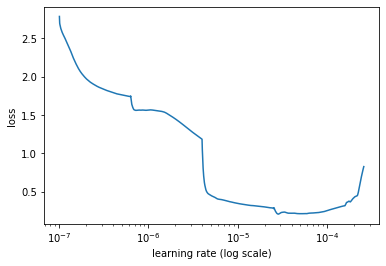

In [ ]:
# simulate training to find good learning rate

learner.lr_find(show_plot=True, max_epochs=10)

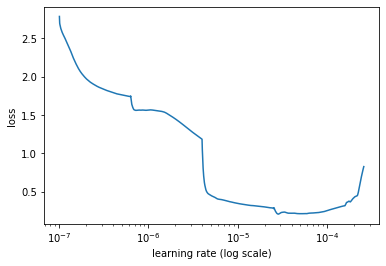

In [ ]:
# visually identify best learning rate

learner.lr_plot()

In [ ]:
#Fitting the model with the learning rate, and automatic epochs. 

learner.autofit(1e-5)

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 1e-05...
Epoch 1/1024
2667/2667 [==============================] - 1917s 712ms/step - loss: 1.2159 - accuracy: 0.5256 - val_loss: 0.1961 - val_accuracy: 0.9225
Epoch 2/1024
2667/2667 [==============================] - 1896s 711ms/step - loss: 0.1729 - accuracy: 0.9305 - val_loss: 0.1576 - val_accuracy: 0.9290
Epoch 3/1024
2667/2667 [==============================] - 1872s 702ms/step - loss: 0.1158 - accuracy: 0.9481 - val_loss: 0.1484 - val_accuracy: 0.9320
Epoch 4/1024
2667/2667 [==============================] - 1873s 702ms/step - loss: 0.0907 - accuracy: 0.9562 - val_loss: 0.1480 - val_accuracy: 0.9290
Epoch 5/1024
2667/2667 [==============================] - 1883s 706ms/step - loss: 0.0804 - accuracy: 0.9616 - val_loss: 0.1346 - val_accuracy: 0.9360
Epoch 6/1024
2667/2667 [==============================] - 186

In [ ]:
#a predictor object for our model
predictor = ktrain.get_predictor(learner.model, preproc)

In [ ]:
#predicting on the test data

predictions = predictor.predict(bert_x_test)

In [ ]:
#printing the classification report

print(classification_report(test['label'].tolist(), predictions))

              precision    recall  f1-score   support

       anger       0.94      0.92      0.93       275
        fear       0.87      0.96      0.91       224
         joy       0.97      0.95      0.96       695
        love       0.82      0.88      0.85       159
     sadness       0.97      0.97      0.97       581
    surprise       0.90      0.70      0.79        66

    accuracy                           0.94      2000
   macro avg       0.91      0.89      0.90      2000
weighted avg       0.94      0.94      0.94      2000



In [ ]:
#Calculating the accuracy, percision, recall, and F1 scores for BERT

acc_score = metrics.accuracy_score(predictions,bert_y_test)
prec_score = precision_score(test['label'].tolist(),predictions, average='macro')
recall = recall_score(test['label'].tolist(), predictions,average='macro')
f1 = f1_score(test['label'].tolist(),predictions,average='macro')
matrix = confusion_matrix(test['label'].tolist(),predictions)

In [ ]:
print(str('BERT Accuracy: '+'{:04.2f}'.format(acc_score*100))+'%')
print(str('BERT Precision: '+'{:04.2f}'.format(prec_score*100))+'%')
print(str('BERT Recall: '+'{:04.2f}'.format(recall*100))+'%')
print('BERT F1 Score: ',f1)
print(matrix)

BERT Accuracy: 0.00%
BERT Precision: 91.01%
BERT Recall: 89.42%
BERT F1 Score:  0.8994393776769228
[[253   9   2   0  11   0]
 [  5 214   0   0   5   0]
 [  2   0 657  29   2   5]
 [  1   0  17 140   1   0]
 [  9   6   3   1 562   0]
 [  0  18   1   0   1  46]]


# **Resources**

## Faster GPUs

With Colab Pro you have priority access to our fastest GPUs. For example, you may get a T4 or P100 GPU at times when most users of standard Colab receive a slower K80 GPU. You can see what GPU you've been assigned at any time by executing the following cell.

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat Jan 16 22:25:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    25W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In order to use a GPU with your notebook, select the Runtime > Change runtime type menu, and then set the hardware accelerator dropdown to GPU.

## More memory

With Colab Pro you have the option to access high-memory VMs when they are available. To set your notebook preference to use a high-memory runtime, select the Runtime > 'Change runtime type' menu, and then select High-RAM in the Runtime shape dropdown.

You can see how much memory you have available at any time by running the following code.


In [1]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


## Longer runtimes

All Colab runtimes are reset after some period of time (which is faster if the runtime isn't executing code). While Colab Pro subscribers still have limits, these will be roughly twice the limits for non-subscribers.

## Resource limits in Colab Pro

Your resources are not unlimited in Colab Pro. To make the most of Colab Pro, please avoid using resources when you don't need them. For example, only use a GPU or high-RAM runtime when required, and close Colab tabs when finished.
